In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline



### Part 1 : Importing Dataset and Overview

Dataset url : https://www.kaggle.com/datasets/amitabhajoy/bengaluru-house-price-data

In [2]:
df1 = pd.read_csv("bengaluru_house_prices.csv")
df1

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


For the modelling, training and price prediction, features like area type, society will not contribute. <br>
We'll drop some of those columns.

In [3]:
df2 = df1.drop(['area_type', 'availability', 'society', 'balcony'], axis = 'columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


### Part 2 : Cleaning

In [4]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

There aren't much of null values, so we'll drop them.

In [5]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

Size column has '2 BHK' and '2 Bedroom' entries which should mean the same. So we'll make a numeric column for that.

In [6]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [7]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


c:\Users\sachi\miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
df4 = df3.drop(['size'], axis='columns')
df4

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056,2.0,39.07,2
1,Chikka Tirupathi,2600,5.0,120.00,4
2,Uttarahalli,1440,2.0,62.00,3
3,Lingadheeranahalli,1521,3.0,95.00,3
4,Kothanur,1200,2.0,51.00,2
...,...,...,...,...,...
13315,Whitefield,3453,4.0,231.00,5
13316,Richards Town,3600,5.0,400.00,4
13317,Raja Rajeshwari Nagar,1141,2.0,60.00,2
13318,Padmanabhanagar,4689,4.0,488.00,4


Converting entries of total_sqft that are in interval to a specific number i.e. boundary's mean. 

In [9]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [10]:
df3[~df3['total_sqft'].apply(is_float)].head()

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2


In [11]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        try:
            # Convert each token to a float after removing leading/trailing spaces
            val1 = float(tokens[0].strip())
            val2 = float(tokens[1].strip())
            return (val1 + val2) / 2
        except:
            return None
    try:
        # Convert the entire string to a float after removing leading/trailing spaces
        return float(x.strip())
    except:
        return None


In [12]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


In Real Estate, price_per_sqft is more conventional, so adding that column.

In [13]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [14]:
df5.to_csv('bhp.csv', index = False)

In [15]:
df5.location = df5.location.apply(lambda x : x.strip())
location_stats = df5['location'].value_counts(ascending=False)



In [54]:
len(location_stats)

1287

In [16]:
len(location_stats[location_stats <=10])

1047

Out of 1287 locations, most of them have less than 10 properties listed. <br>
SO it will be better to group them as 'other' section to make our prediction more accurate.

In [17]:
location_stats_less_than_10 = location_stats[location_stats <=10]
location_stats_less_than_10

BTM 1st Stage                10
Gunjur Palya                 10
Nagappa Reddy Layout         10
Sector 1 HSR Layout          10
Thyagaraja Nagar             10
                             ..
Rajanna Layout                1
Subramanyanagar               1
Lakshmipura Vidyaanyapura     1
Malur Hosur Road              1
Abshot Layout                 1
Name: location, Length: 1047, dtype: int64

In [18]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x )
len(df5.location.unique())

241

In [19]:
df5[df5.total_sqft/df5.bhk<300].head()


,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [20]:
len(df5[df5.total_sqft/df5.bhk<300])

744

Its highly unlikely that area needed to build per BHK is less that 300 sq feet.

In [21]:
df6 = df5[(df5['total_sqft']/df5['bhk']) >=300]
df6

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
...,...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5,6689.834926
13316,other,4 BHK,3600.0,5.0,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2,5258.545136
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4,10407.336319


In [22]:
df6['price_per_sqft'].describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

### Part 3 : Outliers Removal

We have some exceptions in properties having very high and low prices. To build a more generalised model, we have to remove those outliers.<br>
We'll keep those properties whose price lie in range [mean - std_dev, mean + std_dev]

In [23]:
def remove_outliers(df):
    df_ans = pd.DataFrame()
    
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf['price_per_sqft'] > (m-st)) & (subdf['price_per_sqft'] < (m+st) )]
        df_ans = pd.concat([df_ans, reduced_df], ignore_index = True)
    
    return df_ans


        

In [24]:
df7 = remove_outliers(df6)
df7.shape

(10242, 7)

In [55]:
def plot_scatter_chart(df, location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    plt.scatter(bhk2['total_sqft'], bhk2['price'], color = 'blue', label = '2bhk', s= 50)
    plt.scatter(bhk3['total_sqft'], bhk3['price'], color = 'red', label = '3bhk', marker = '+', s= 50)
    plt.xlabel('Total sqft')
    plt.ylabel('Price in Lakhs')
    plt.title(location)
    plt.legend()   
    matplotlib.rcParams['figure.figsize'] = (15,10)

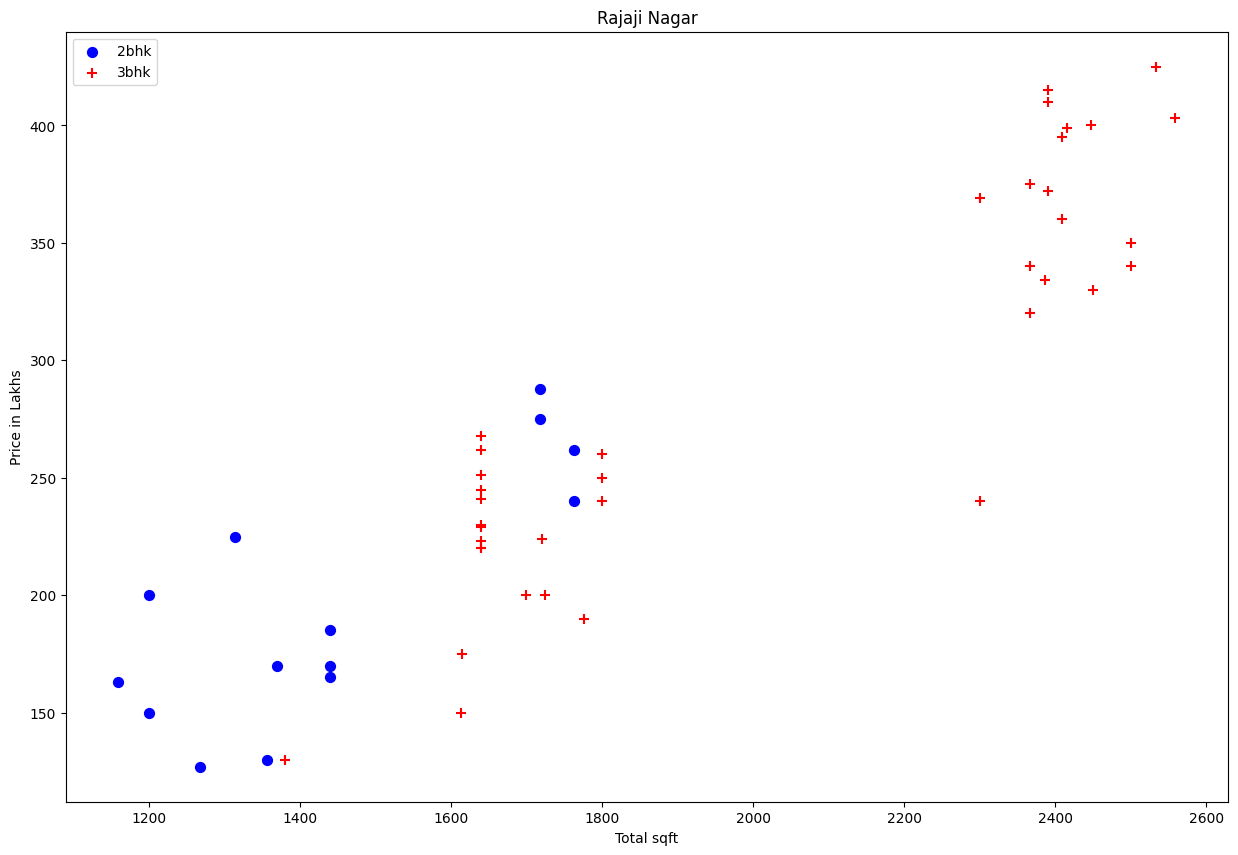

In [57]:
plot_scatter_chart(df7, 'Rajaji Nagar')


From above plot, for Rajaji Nagar, we can notice for the similar area, 2 BHK are expensive that 3 BHK. This could be happening in all other areas.

In [27]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean' : np.mean(bhk_df['price_per_sqft']),
                'std' : np.std(bhk_df['price_per_sqft']),
                'count' : bhk_df.shape[0]             
            }
        
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df['price_per_sqft'] < (stats['mean'])].index.values)
    
    return df.drop(exclude_indices, axis = 'index')
    

In [58]:
df8 = remove_bhk_outliers(df7)
df8.shape


(7317, 7)

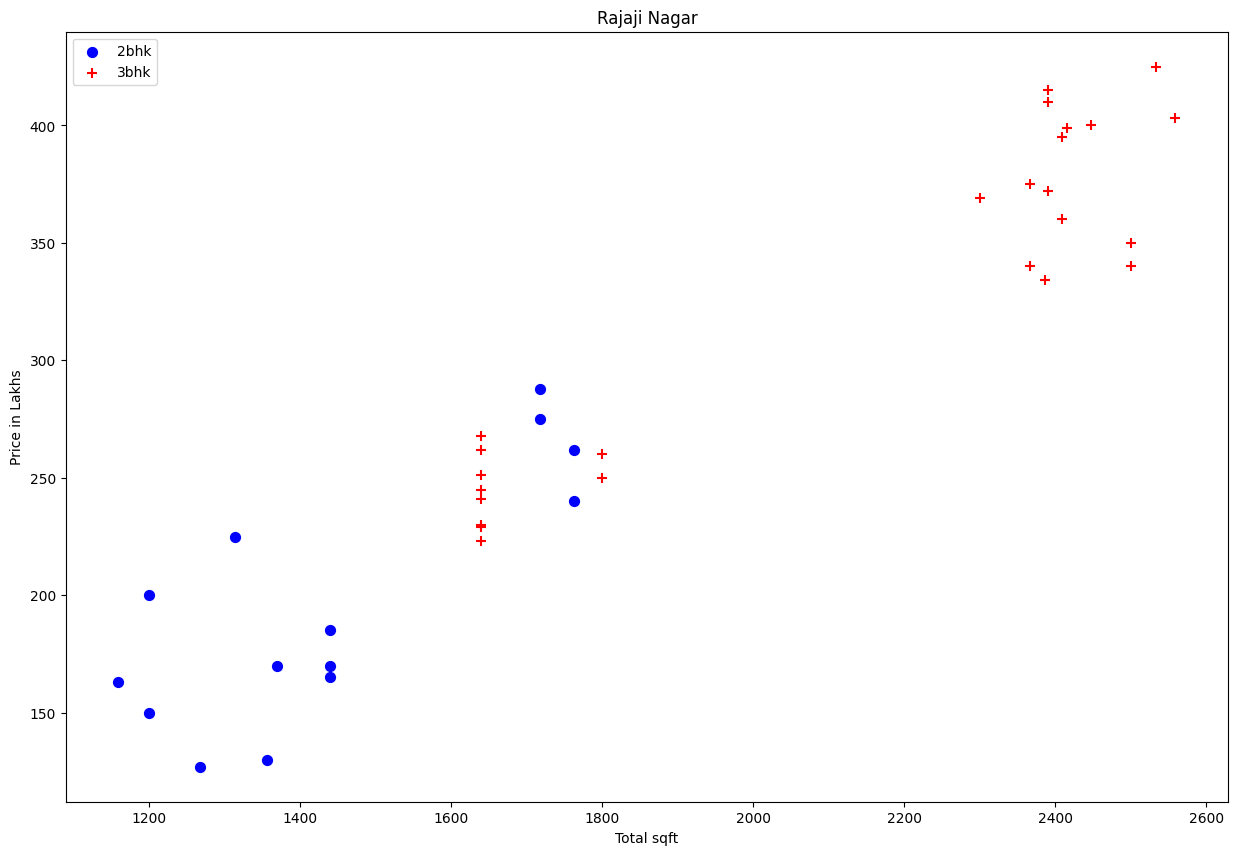

In [59]:
plot_scatter_chart(df8, 'Rajaji Nagar')

Text(0, 0.5, 'Count')

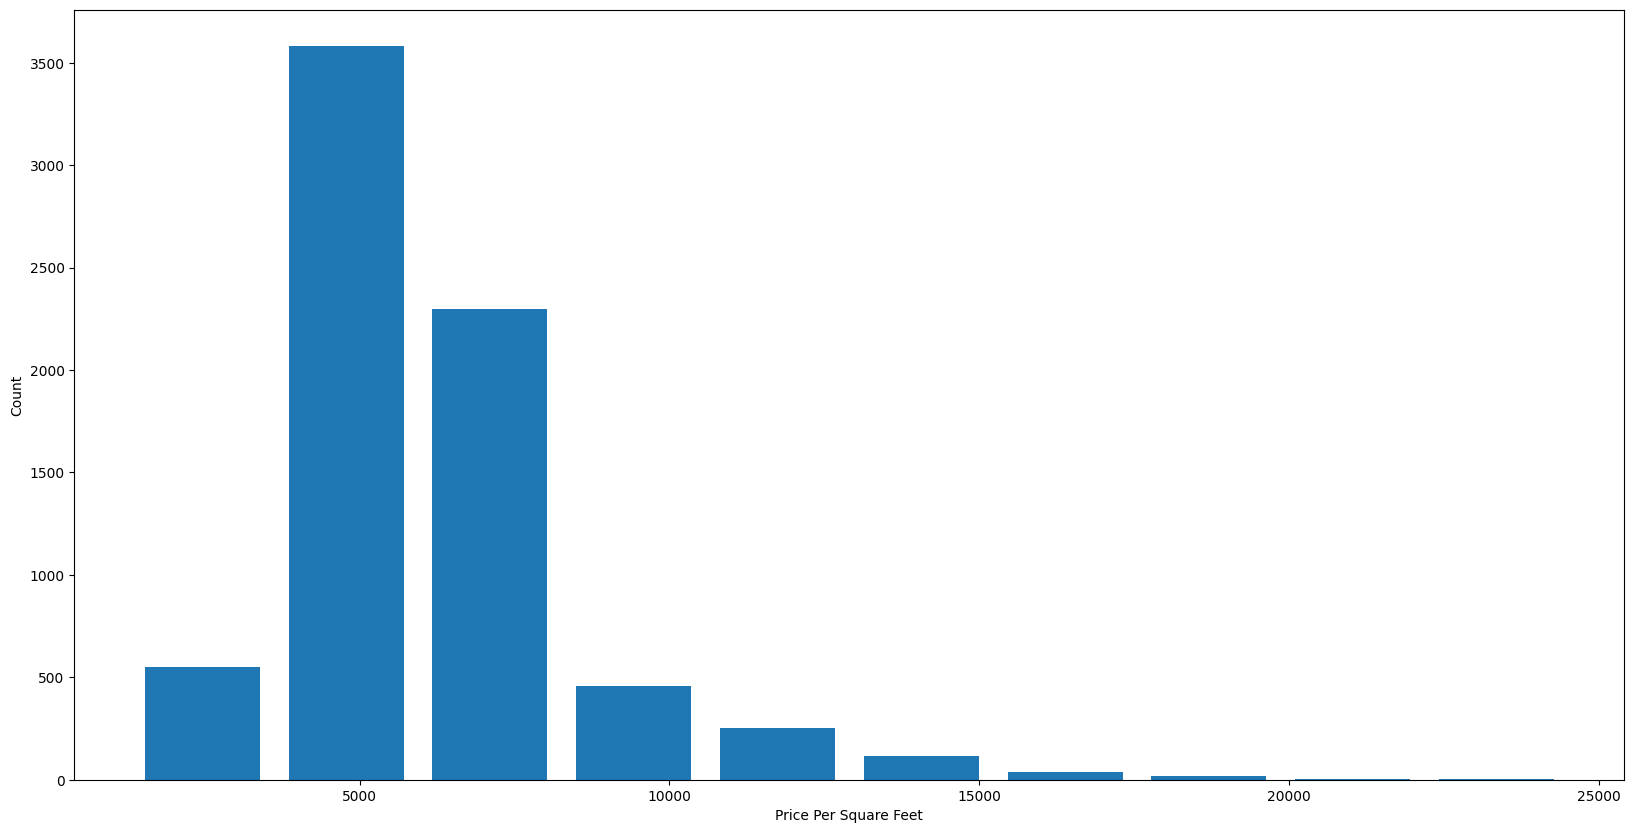

In [30]:
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

In [31]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'count')

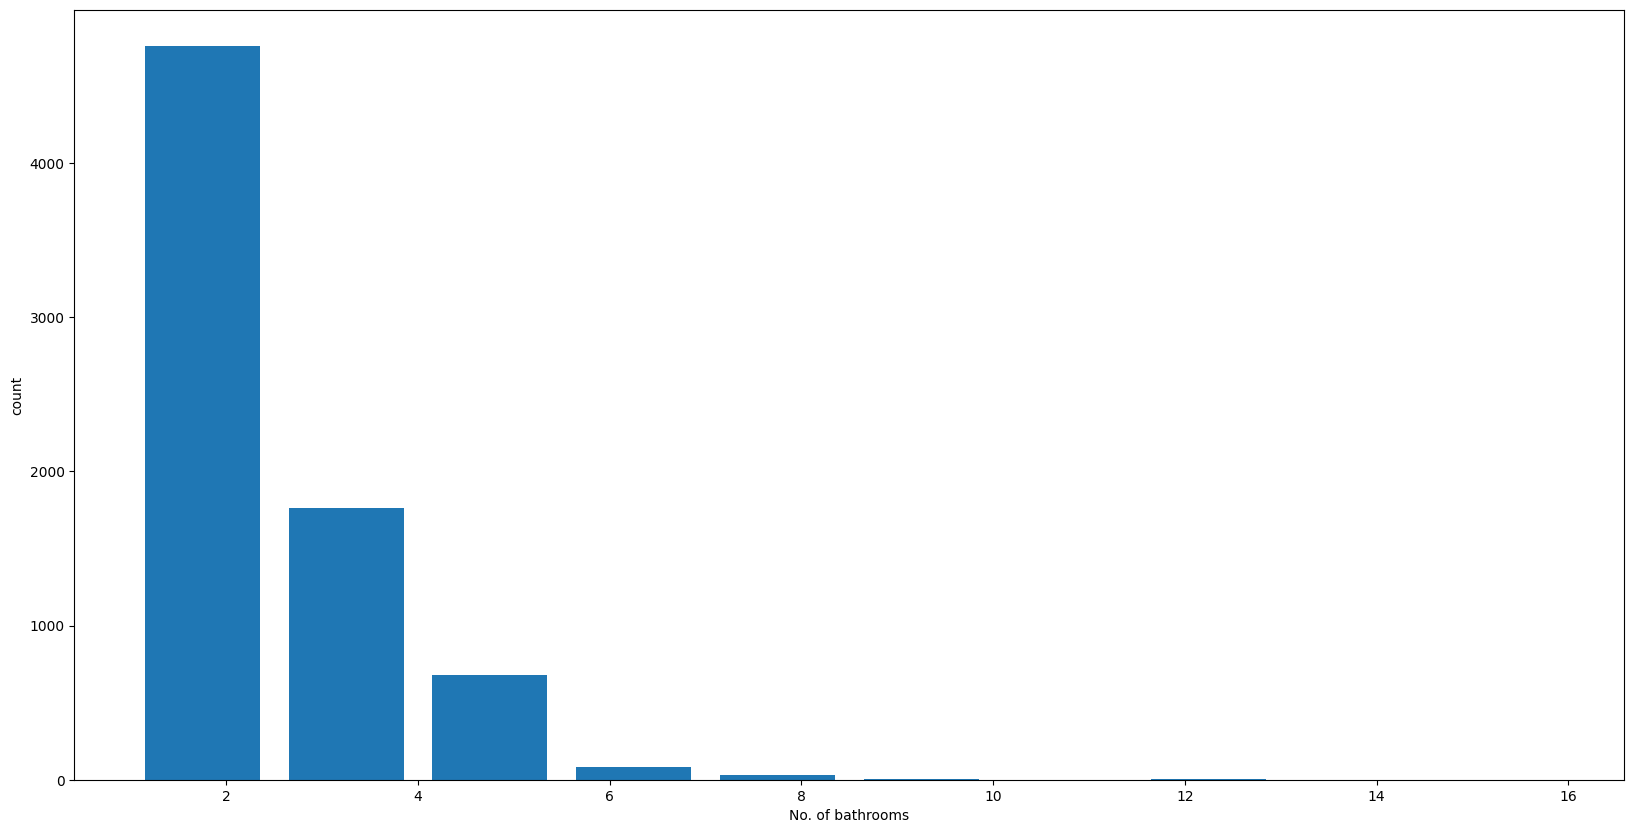

In [32]:
plt.hist(df8.bath, rwidth = 0.8)
plt.xlabel("No. of bathrooms")
plt.ylabel("count")

In [33]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


Usually number of bathrooms in a flat is somewhat 2-3 more than number of bedrooms.

In [34]:
df9 = df8[df8.bath<df8.bhk+2]
df9

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668
...,...,...,...,...,...,...,...
10233,other,2 BHK,1200.0,2.0,70.0,2,5833.333333
10234,other,1 BHK,1800.0,1.0,200.0,1,11111.111111
10237,other,2 BHK,1353.0,2.0,110.0,2,8130.081301
10238,other,1 Bedroom,812.0,1.0,26.0,1,3201.970443


In [35]:
df9.shape


(7239, 7)

In [36]:
df10 = df9.drop(['size','price_per_sqft'], axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


### Part 4 : One hot encoding of location 

In [37]:
dummies = pd.get_dummies(df10.location)
dummies

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [38]:
dummies.drop(['other'], axis='columns', inplace=True)
dummies

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
df11 = pd.concat([df10, dummies], axis = 'columns')
df11

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10233,other,1200.0,2.0,70.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10234,other,1800.0,1.0,200.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10237,other,1353.0,2.0,110.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10238,other,812.0,1.0,26.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
df12 = df11.drop(['location'], axis = 'columns')
df12

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10233,1200.0,2.0,70.0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10234,1800.0,1.0,200.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10237,1353.0,2.0,110.0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10238,812.0,1.0,26.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
df12.shape

(7239, 244)

### Part 5 : Modelling and Training

In [42]:
X = df12.drop(['price'], axis = 'columns')
X

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10233,1200.0,2.0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10234,1800.0,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10237,1353.0,2.0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10238,812.0,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
y = df12['price']
y

0        428.0
1        194.0
2        235.0
3        130.0
4        148.0
         ...  
10233     70.0
10234    200.0
10237    110.0
10238     26.0
10241    400.0
Name: price, Length: 7239, dtype: float64

In [44]:
print(X.shape, len(y))

(7239, 243) 7239


In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)


In [46]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.8629132245229445

In [47]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size = 0.2, random_state = 0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.82702546, 0.86027005, 0.85322178, 0.8436466 , 0.85481502])

### PArt 6 : Parameter tuning for best model

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def best_model(X, y):
    algos = {
        'linear_regression' : {
            'model' : LinearRegression(), 
            'params' : {
                'fit_intercept' : [True, False]
            }
        },
        
        'lasso' : {
            'model' : Lasso(),
            'params' : {
                'alpha' : [1,2],
                'selection' : ['random', 'cyclic']
            }
        },
        
        'decision_tree' : {
            'model' : DecisionTreeRegressor(),
            'params' : {
                'criterion' : ['mse', 'friedman_mse'],
                'splitter' : ['best', 'random']
            }
        }
    }
    
    scores = []
    cv = cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
 
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'],config['params'],cv=cv, return_train_score = False)
        gs.fit(X,y)
       
        scores.append({
            'model' : algo_name,
            'best_score' : gs.best_score_,
            'best_params' : gs.best_params_
        })
        
    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [49]:
best_model(X,y)

c:\Users\sachi\miniconda3\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
c:\Users\sachi\miniconda3\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
c:\Users\sachi\miniconda3\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
c:\Users\sachi\miniconda3\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
c:\Users\sachi\miniconda3\lib\site-packages\sklearn\tree\_classe

,model,best_score,best_params
0,linear_regression,0.847951,{'fit_intercept': False}
1,lasso,0.726738,"{'alpha': 2, 'selection': 'cyclic'}"
2,decision_tree,0.670409,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [50]:
def predict_price(location, sqft, bath, bhk):
    loc_index = np.where(X.columns == location)[0][0]
    
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >=0:
        x[loc_index] = 1
    
    return lr_clf.predict([x])[0] 

In [51]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

c:\Users\sachi\miniconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


83.86570258311801

In [52]:
predict_price('1st Phase JP Nagar',1000, 3, 2)

c:\Users\sachi\miniconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


87.58264928988572

In [53]:
predict_price('Indira Nagar',1000, 3, 3)


c:\Users\sachi\miniconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


195.52689759854528